In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna

/Users/sudevchirappat/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [107]:
# df_abs = pd.read_csv('Data/labelled_vector_50000cross301.csv',index_col=0)
# df_nor = pd.read_csv('Data/final_unit_vector.csv')
# df_awt = pd.read_csv('Data/vector_with_text.csv')
df = pd.read_csv('Data/Training_Data/alldata_embedded_vector_norm.csv')

In [108]:
df.label.value_counts()

Sports           156899
Politics          87157
Entertainment     50281
Finance           47851
Tech              41475
Name: label, dtype: int64

In [118]:
def numerize_label(s):
    d = {'Society|Politics':0,
         'Economy|Finance' : 1,
         'Tech' : 2,
         'Sports' :3,
         'Entertainment' :4,
         'Science' :5,
         'Other' :6}
    return s.replace(d, regex=True).map(lambda x : int(x))
    

In [136]:
def labelize_numeric(arr):
    d = {0:'society',
         1:'economy',
         2:'technology',
         3:'sports',
         4:'entertainment',
         5:'science',
         6:'other'}
    
    return [d[k] for k in arr]

In [119]:
y = numerize_label(df['label'])

In [121]:
def setup_data_for_training(df,drop_cols = ['label']):
    # get the labels
    y = numerize_label(df['label'])
    
    x = df.drop(drop_cols, axis=1)

    #
    # Create training and validation sets
    #

    # x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    return train_data,val_data,test_data,y_label_map

In [122]:
train_data,val_data,test_data,y_label_map = setup_data_for_training(df,['label'])

In [123]:
train_data.data.shape,val_data.data.shape,test_data.data.shape

((245544, 300), (61386, 300), (76733, 300))

In [124]:
#
# Train the model
#
parameters = {
          "objective" : "multiclass",
          "num_class" : 5,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.1,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : -1 }

In [125]:
%%time
model = lgb.train(parameters,
                       train_data,
                       valid_sets=val_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[1]	valid_0's multi_logloss: 1.42027
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.37622
[3]	valid_0's multi_logloss: 1.33865
[4]	valid_0's multi_logloss: 1.3057
[5]	valid_0's multi_logloss: 1.27637
[6]	valid_0's multi_logloss: 1.25078
[7]	valid_0's multi_logloss: 1.22797
[8]	valid_0's multi_logloss: 1.20719
[9]	valid_0's multi_logloss: 1.18883
[10]	valid_0's multi_logloss: 1.17171
[11]	valid_0's multi_logloss: 1.15623
[12]	valid_0's multi_logloss: 1.14238
[13]	valid_0's multi_logloss: 1.12965
[14]	valid_0's multi_logloss: 1.1181
[15]	valid_0's multi_logloss: 1.10738
[16]	valid_0's multi_logloss: 1.09744
[17]	valid_0's multi_logloss: 1.08819
[18]	valid_0's multi_logloss: 1.07972
[19]	valid_0's multi_logloss: 1.0719
[20]	valid_0's multi_logloss: 1.06446
[21]	valid_0's multi_logloss: 1.05756
[22]	valid_0's multi_logloss: 1.05116
[23]	valid_0's multi_logloss: 1.04506
[24]	valid_0's multi_logloss: 1.03954
[25]	valid_0's multi_logloss: 1.03434


In [126]:
m_name = 'assets/models/lgb_model_all_data.txt'
model.save_model(m_name)

In [127]:
# %%time
# # load model to predict
# model = lgb.Booster(model_file=m_name)

In [128]:
%%time
y_pred = model.predict(test_data.data)

CPU times: user 41.8 s, sys: 390 ms, total: 42.2 s
Wall time: 5.56 s


In [129]:
max_p_index = np.argmax(y_pred,axis=1)

In [130]:
(max_p_index == test_data.label).mean()

0.5848852514563486

In [131]:
y_pred_df = pd.DataFrame(y_pred,columns=y_label_map)

In [132]:
y_pred_df.head()

,Entertainment,Finance,Politics,Sports,Tech
0,0.073947,0.096994,0.130902,0.197797,0.500360
1,0.017927,0.237443,0.033928,0.676694,0.034008
2,0.085593,0.436856,0.127422,0.095288,0.254840
3,0.002269,0.000060,0.000069,0.892773,0.104830
4,0.035892,0.262365,0.159947,0.284633,0.257163


In [133]:
t = test_data.data.copy()

In [134]:
# To get the actual text
d = pd.read_csv('Data/Training_Data/alldata_tokenized.csv',usecols=['text'])

In [135]:
t['text'] = d[d.index.isin(t.index)]['text']

In [44]:
t.reset_index(drop=True, inplace=True)
y_pred_df.reset_index(drop=True, inplace=True)

pred_df = pd.concat([t,y_pred_df],axis=1)

pred_df['max_p_label'] = y_label_map[max_p_index]

pred_df['original_label'] = y_label_map[test_data.label]

In [58]:
# Save this prediction to file
pred_df.iloc[:,300:].to_csv('Data/Training_Data/all_data_test_set_pred.csv',index=False)

In [52]:
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(pred_df['original_label'], pred_df['max_p_label'],labels=y_label_map)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.55 0.07 0.03 0.28 0.07]
 [0.05 0.62 0.05 0.14 0.14]
 [0.03 0.06 0.47 0.4  0.04]
 [0.05 0.03 0.24 0.67 0.02]
 [0.1  0.18 0.06 0.13 0.52]]


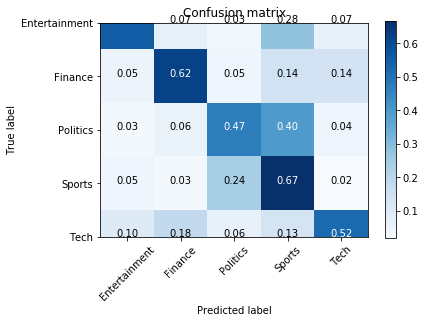

In [53]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=y_label_map,normalize=True)

In [165]:
from bs4 import BeautifulSoup
import os
from multiprocessing import Pool
import glob
TG_DATA = "./Data/TG_Data"

def read_filelist(folder_path = "."):
    r_path = os.path.join(folder_path, "**/*.html")
    file_list = [f for f in glob.glob(r_path, recursive=True)]
    return file_list

%%time
file_list = read_filelist(TG_DATA)

def get_soup(file):
    with open(file,'r') as file_ptr:
        soup = BeautifulSoup(file_ptr,'lxml')
    return soup

def extract_text(soup,tag = 'all'):
    assert tag in ['all','p','h1']
    if tag == 'all':
        text = soup.text.strip()
    else:
        p_contents = soup.find_all(tag)
        text = ""
        for p in p_contents:
            text = text + p.getText()
    return text

def parse_html_file(file):
    soup = get_soup(file)
    d = extract_meta(soup)
    d['p_text'] = extract_text(soup,'p')
    return d

%%time
def load_vectors(fname): 
    import io
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return n,d,data

n,d,ft_dict = load_vectors("assets/wiki-news-300d-1M.vec")

def get_ft_vec(token,ft_dict,d=300):
    try:
        v = np.array(ft_dict[token])
    except KeyError:
        v = np.array([0]*d)
    return v

def compute_ft_sum(textlist,ft_dict,d=300):
    ret_vec = np.array([0]*d)
    for key in textlist:
        vec = get_ft_vec(key,ft_dict)
        # Vector addition of token embeddings
        ret_vec = ret_vec + vec
    return list(ret_vec)

def compute_doc_ft(fname,ft_dict):
    parse_html_file(fname)
    # Read html text
    import text_preprocessing as tp
    arr = tp.preprocess(doc_text)
    vector = compute_ft_sum(arr, ft_dict)
    return vector


In [ ]:
# %%time
# pool = Pool()
# results= pool.map(parse_html_file, file_list)
# pool.close()

In [ ]:
# Load FT vectors:


In [ ]:
import parmap
# In parallel:
y = parmap.map(compute_doc_ft, file_list, ft_dict)

In [1]:
!which python

/Users/sudevchirappat/opt/anaconda3/bin/python


In [ ]:
%%time
pool = Pool()
results= pool.map(detect_langage, list(df_headline['text']))
pool.close()